In [1]:
import pyrootutils
import numpy as np
import os

In [2]:
PROJECT_ROOT = path = pyrootutils.find_root(
    search_from=os.path.abspath(''), indicator=".project-root"
)

In [4]:
from tokenizers import Tokenizer
from src.tokenizer_metrics import SingleTokenizerMetric, AverageTokenLength, AlignmentWithCDI, TokenizerOverlap, CorrespondenceWithWords, CorrespondenceWithMorphemes, SplitsIntoMorphemes, SplitsOnSpace

/opt/homebrew/Caskroom/miniconda/base/envs/ccm_proj/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [7]:
# ADD TOKENIZERS TO RUN HERE!

tokenizers = {}
tokenizers['BPE 10 splits no retrain'] = [Tokenizer.from_file(str(PROJECT_ROOT / f"outputs/2024-04-22-144844_30cf/tokenizer_{i}.json")) for i in range(1,11)]
tokenizers['BPE 10 splits retrain'] = [Tokenizer.from_file(str(PROJECT_ROOT / f"outputs/2024-04-22-145055_617e/tokenizer_{i}.json")) for i in range(1,10)]

In [8]:
multitokenizer_metrics = [AlignmentWithCDI, TokenizerOverlap]
metric_names = [tokenizer_metric.__qualname__ for tokenizer_metric in multitokenizer_metrics]
scores = {}
for tokenizer_type, tokenizer_list in tokenizers.items():
    scores[tokenizer_type] = [metric(tokenizer_list).calculate() for metric in multitokenizer_metrics]

0.10640810010387322 0.12700710917866764
0.17091991998728975 0.005820740739759016


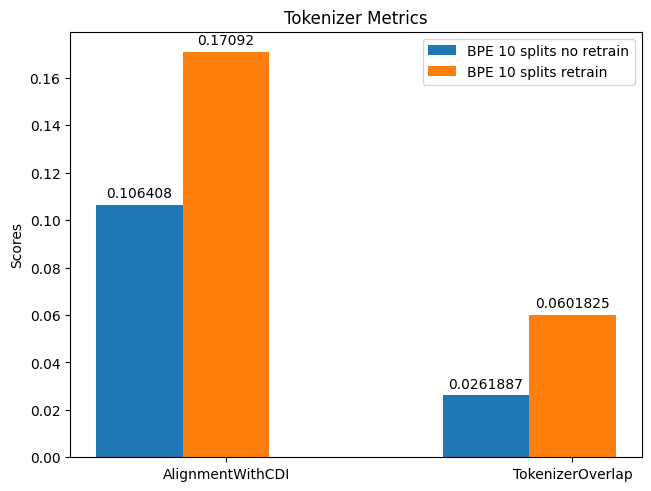

In [9]:
x = np.arange(len(scores))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in scores.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Tokenizer Metrics')
ax.set_xticks(x + width, metric_names)
ax.legend()
plt.show()

In [10]:
def plot_comparison(metric:dict[str, float], metric_name: str):
    plt.figure()
    plt.clf()
    for tok_type, values in metric.items():
        plt.plot(values, label=tok_type)
    plt.ylabel('Score')
    plt.xlabel('Tokenizer Iteration')
    plt.title(metric_name)
    plt.legend() 
    plt.show()

def calculate_and_plot(metric_name: SingleTokenizerMetric, **args):
    values = {}
    for tok_type, tok_list in tokenizers.items():
        scores = []
        for tok in tok_list:
            x = metric_name(tok, **args)
            scores.append(x.calculate())
        values[tok_type] = scores
    plot_comparison(values, metric_name=metric_name.__qualname__)

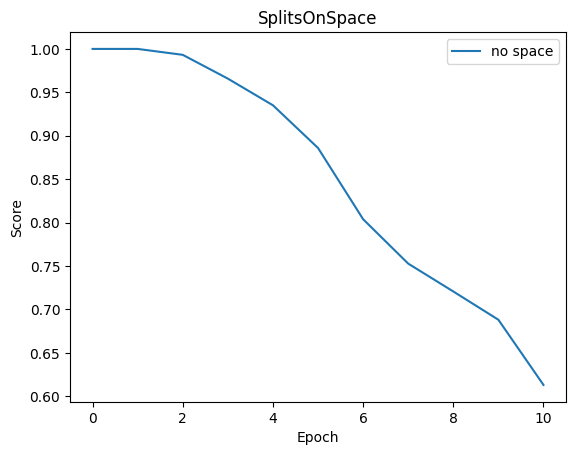

In [10]:
nospace_tokenizers = [Tokenizer.from_file(str(PROJECT_ROOT / f"outputs/2024-05-04-015934_1db9/tokenizer_{i}.json")) for i in range(0,11)]
# percentage of spaces that correspond to token boundaries
scores = []
for tok in nospace_tokenizers:
    x = SplitsOnSpace(tok)
    scores.append(x.calculate())
plot_comparison({"no space": scores}, metric_name=SplitsOnSpace.__name__)

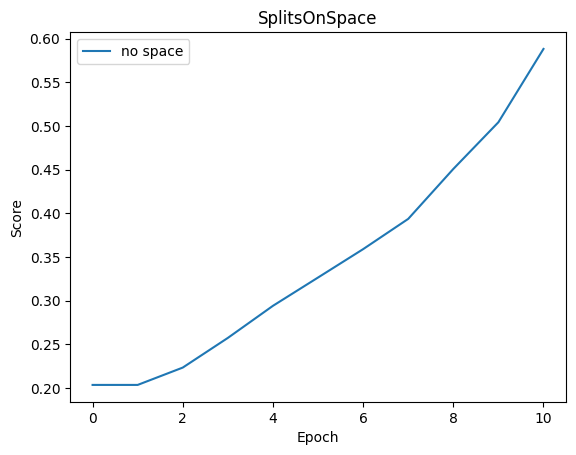

In [12]:
# percentage of tokenized boundaries that correspond to actual spaces
scores = []
for tok in nospace_tokenizers:
    x = SplitsOnSpace(tok, baseline="tokenized")
    scores.append(x.calculate())
plot_comparison({"no space": scores}, metric_name=SplitsOnSpace.__name__)

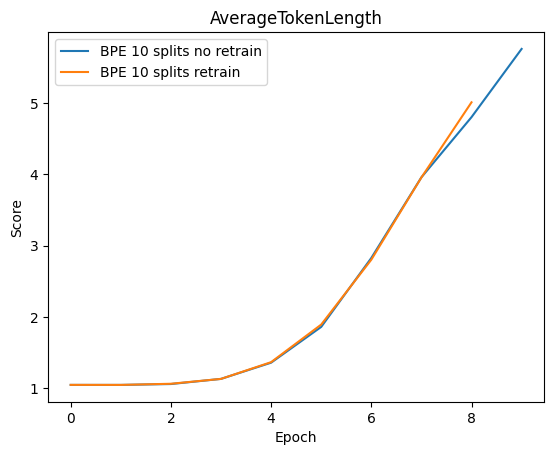

In [11]:
calculate_and_plot(AverageTokenLength)

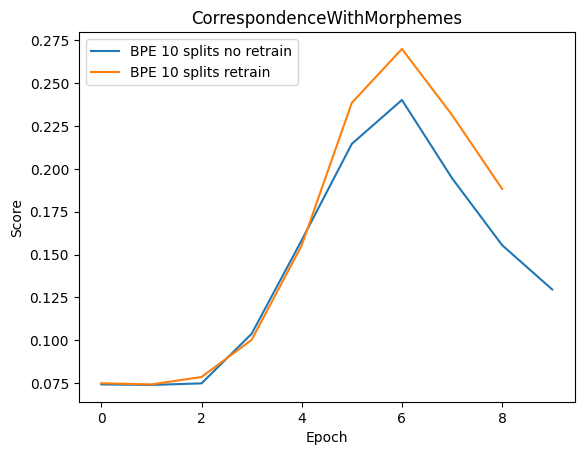

In [12]:
calculate_and_plot(CorrespondenceWithMorphemes)

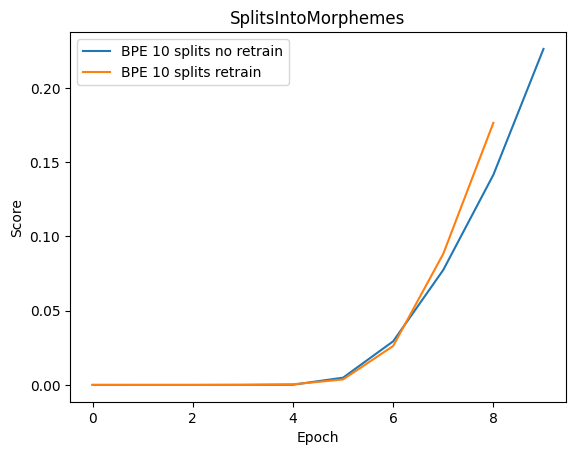

In [13]:
calculate_and_plot(SplitsIntoMorphemes, metric="count")

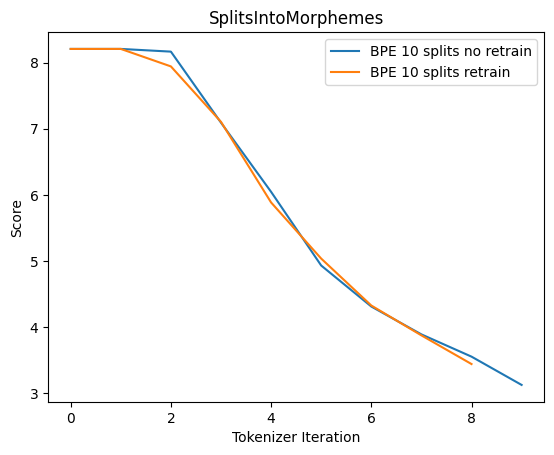

In [12]:
calculate_and_plot(SplitsIntoMorphemes, metric="distance")